# Analysis Pipeline

## Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
pd.set_option('display.max_columns', None)

## Global variables / settings for this notebook

In [3]:
subject_no = 6

In [33]:
subject_no = 6
# subject-independant directory and filename of raw-data
input_subject_file = f"..\\data\\preprocessed\\subject-{subject_no}.tsv"
# path to stimuli of experiment
exp_stimuli_folder = "..\\stimuli\\"
# set global colormap var
cmp = plt.cm.viridis_r
# display resolution
display = {"width": 1920, "height": 1080}

In [5]:
# read data
data = pd.read_csv(input_subject_file, sep="\t", header=0)

# clean up sentence_id
for index, value in data['SENTENCE_ID'].items():
    if pd.notna(value):
        if type(value) == float:
            data.at[index, "SENTENCE_ID"] = str(int(data.at[index, "SENTENCE_ID"]))
        elif ".0" in value:
            data.at[index, "SENTENCE_ID"] = str(data.at[index, "SENTENCE_ID"].split('.')[0])

C:\Users\CleresAndreK\AppData\Local\Temp\ipykernel_3828\3531856154.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_subject_file, sep="\t", header=0)


## Create asset directory for subject

In [6]:
# Define the folder name
plt_folder_name = f'..\\plots\\subject-{subject_no}'

# Check if the folder exists, if not, create it
if not os.path.exists(plt_folder_name):
    os.makedirs(plt_folder_name)
    print(f"Folder {plt_folder_name} created.")
else:
    print(f"Folder {plt_folder_name} already exists. Skipping...")

plots_folder_name = os.path.abspath(plt_folder_name)

Folder ..\plots\subject-6 already exists. Skipping...


## 3. Additional sanity check

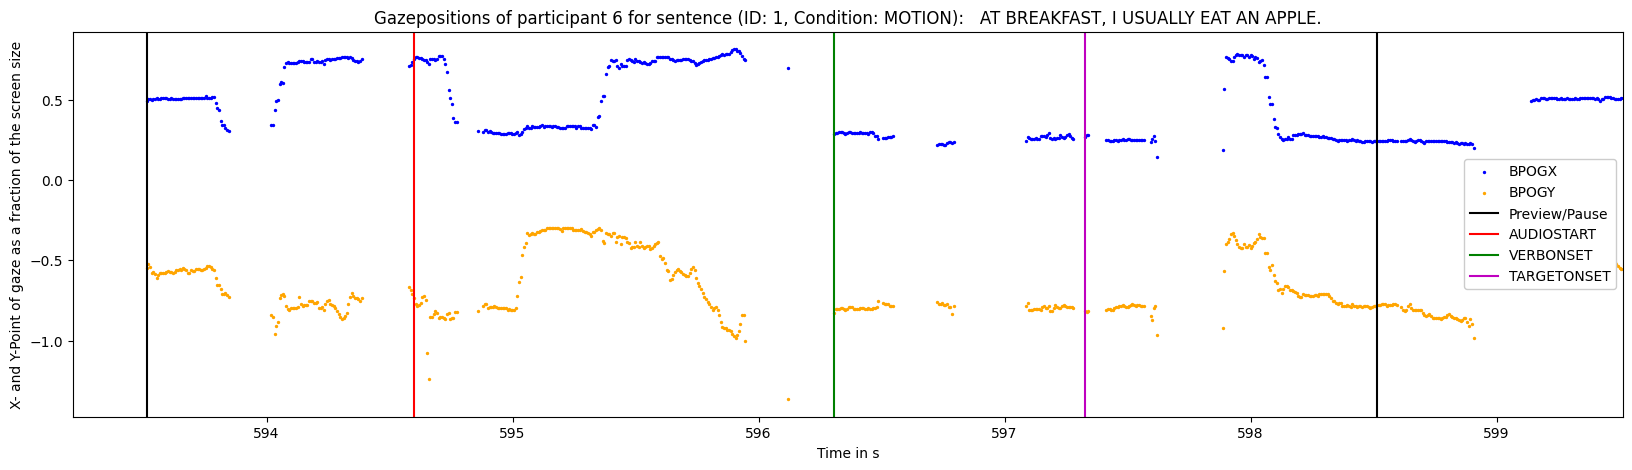

In [7]:
# areas of interest
def calc_aoi(data, sentence_id):

    # get samples with specific id
    data_subset = data.query(f"SENTENCE_ID=='{sentence_id}'")
    data_subset = data_subset.query(f"EVENT=='PREVIEW' or EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET' or EVENT=='PAUSE'")

    # filter invalid samples
    data_subset = data_subset.query("BPOGV==1 and BPOGX>=0 and BPOGY >=0")
    
    # sort by time
    data_subset = data_subset.sort_values(by="TIME", ascending=True)

    # reset index
    data_subset = data_subset.reset_index(drop=True)

    # get cuest    
    preview = data_subset.query("EVENT=='PREVIEW'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
    audiostart = data_subset.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
    verb_onset = data_subset.query("EVENT=='VERBONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
    target_onset = data_subset.query("EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
    pause = data_subset.query("EVENT=='PAUSE'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]

    # define sentence for title
    stc = data_subset.loc[0, "SENTENCE"]
    condition = data_subset.loc[0, "CONDITION"]

    # plot 
    fig = plt.figure(figsize=(20,5))
    
    plt.scatter(data_subset["TIME"],data_subset["BPOGX"],s=2,color="blue",label="BPOGX")
    plt.scatter(data_subset["TIME"],data_subset["BPOGY"]-1,s=2,color="orange",label="BPOGY")

    # labels and ticks
    plt.axvline(x = preview, color = 'k', label = 'Preview/Pause')
    plt.axvline(x = audiostart, color = 'r', label = 'AUDIOSTART')
    plt.axvline(x = verb_onset, color = 'g', label = 'VERBONSET')
    plt.axvline(x = target_onset, color = 'm', label = 'TARGETONSET')
    plt.axvline(x = pause, color = 'k')

    plt.title("Gazepositions of participant " + str(subject_no) + " for sentence (ID: " + str(sentence_id) + ", Condition: " + condition + "):  " + stc)
    plt.xlabel("Time in s")
    plt.ylabel("X- and Y-Point of gaze as a fraction of the screen size")
    plt.xlim((preview-.3, pause+1))
    plt.legend(loc="center right", framealpha=1)

    # save plot to assets
    fig.savefig(f'{plots_folder_name}/3-sanity-gazepos_{str(sentence_id)}_{condition.lower()}.png')

calc_aoi(data, 1)

## 4. Analysis

### 4.1. Scanpath

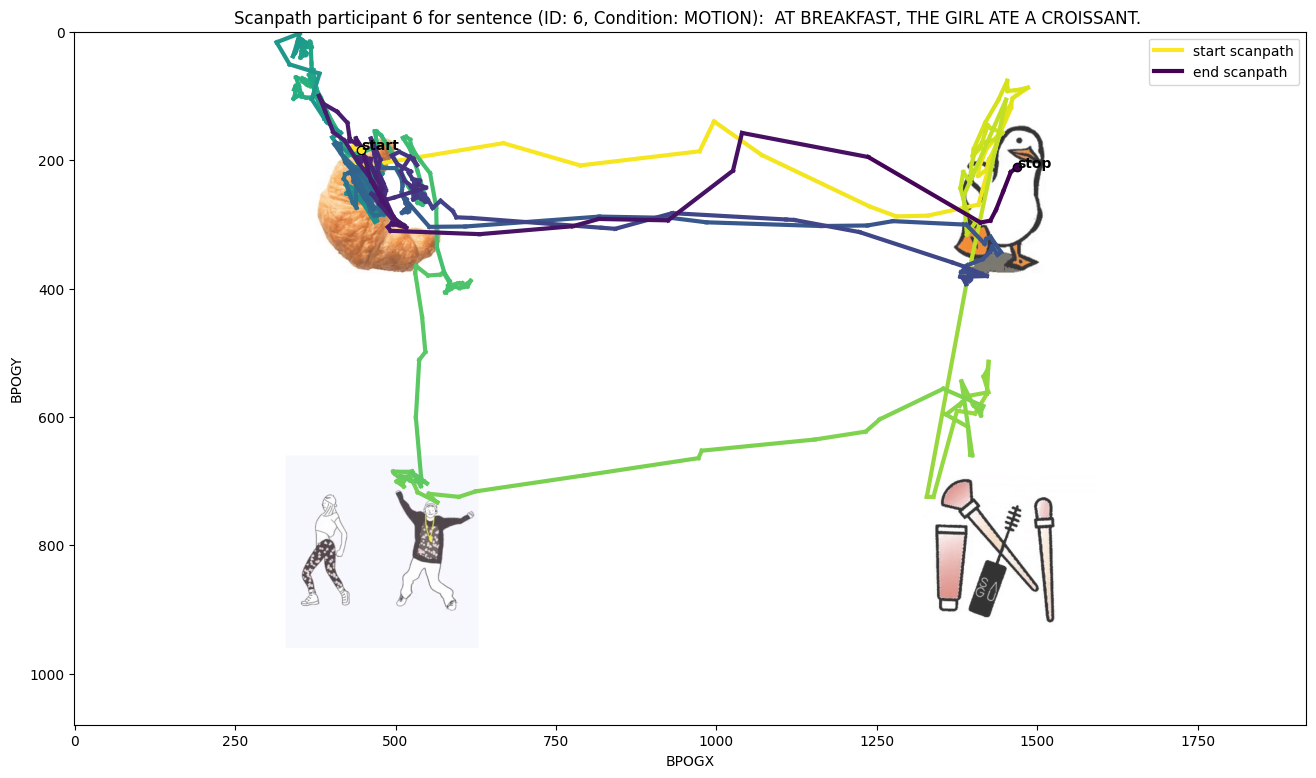

In [31]:
def show_scanpath(data, sentence_id):

    # get samples with specific id
    data_subset = data.query(f"SENTENCE_ID=='{sentence_id}'")
    data_subset = data_subset.query(f"EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET'")

    # filter invalid samples
    data_subset = data_subset.query("BPOGV==1 and BPOGX>=0 and BPOGY >=0")
    
    # reset index
    data_subset = data_subset.reset_index(drop=True)

    # get first row of dataframe
    first_row = data_subset.iloc[0]

    # get position to monitor size
    for index, value in data_subset['BPOGX'].items():
        data_subset.at[index, 'BPOGX'] = value * display['width']
    for index, value in data_subset['BPOGY'].items():
        data_subset.at[index, 'BPOGY'] = value * display['height']

    # sentence information
    stc = first_row["SENTENCE"]
    stc_id = first_row["SENTENCE_ID"]
    condition = data_subset.loc[0, "CONDITION"]

    # plot
    fig = plt.figure(figsize=(16, 9))
    plt.title("Scanpath participant " + str(subject_no) + " for sentence (ID: " + stc_id + ", Condition: " + condition + "):  " + stc)
    
    # background image
    im = plt.imread(exp_stimuli_folder + stc_id + "-" + condition + ".png")
    plt.imshow(im, alpha=.8)
    
    norm_time = (data_subset['TIME'] - data_subset['TIME'].min()) / (data_subset['TIME'].max() - data_subset['TIME'].min())
    dat_sub_len = len(data_subset) - 1

    for i in range(dat_sub_len):
        
        plt.plot(
            data_subset.iloc[i:i+2]['BPOGX'], 
            data_subset.iloc[i:i+2]['BPOGY'], 
            c=cmp(norm_time.iloc[i]),
            linewidth=3,
            label='start scanpath' if i == 0  else 'end scanpath' if i == dat_sub_len-1 else ""
        )
    
    # scanpath start marker
    plt.text(data_subset.iloc[0]['BPOGX'], data_subset.iloc[0]['BPOGY'], 'start', fontweight='bold')
    plt.plot(data_subset.iloc[0]['BPOGX'], data_subset.iloc[0]['BPOGY'], color=cmp(norm_time.iloc[0]), marker='o', markeredgecolor='black', linewidth=100)
    # scanpath stop marker
    plt.text(data_subset.iloc[dat_sub_len]['BPOGX'], data_subset.iloc[dat_sub_len]['BPOGY'], 'stop', fontweight='bold')
    plt.plot(data_subset.iloc[dat_sub_len]['BPOGX'], data_subset.iloc[dat_sub_len]['BPOGY'], color=cmp(norm_time.iloc[dat_sub_len]), marker='o', markeredgecolor='black', linewidth=100)
    
    # labels and ticks
    plt.xlabel("BPOGX")
    plt.ylabel("BPOGY")
    plt.legend()
    
    # display scanpath
    plt.show()

    # save plot to assets
    fig.savefig(f'{plots_folder_name}/4-analysis-scanpath_{str(sentence_id)}_{condition.lower()}.png')


show_scanpath(data, 6)

### 4.2. Heatmap

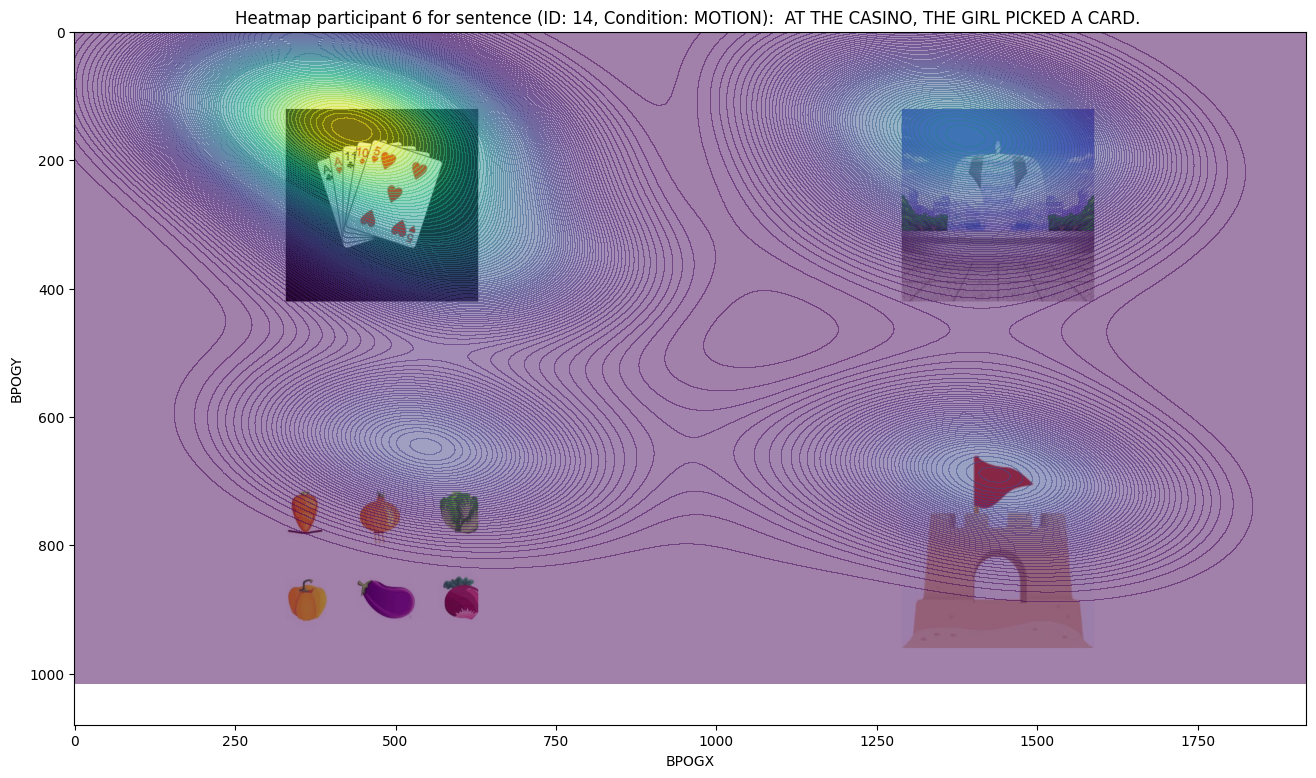

In [36]:
# heatmap
def show_heatmap(data, sentence_id):

    # get samples with specific id
    data_subset = data.query(f"SENTENCE_ID=='{sentence_id}'")
    data_subset = data_subset.query(f"EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET'")

    # filter invalid samples
    data_subset = data_subset.query("BPOGV==1 and BPOGX>=0 and BPOGY >=0")
    
    # reset index
    data_subset = data_subset.reset_index(drop=True)

    # get first row of dataframe
    first_row = data_subset.iloc[0]

    for index, value in data_subset['BPOGX'].items():
        data_subset.at[index, 'BPOGX'] = value * display['width']
    for index, value in data_subset['BPOGY'].items():
        data_subset.at[index, 'BPOGY'] = value * display['height']

    stc = first_row["SENTENCE"]
    stc_id = first_row["SENTENCE_ID"]
    condition = data_subset.loc[0, "CONDITION"]
    

    # plot
    fig = plt.figure(figsize=(16, 9))
    
    sns.kdeplot(data=data_subset, x='BPOGX', y='BPOGY', fill=True, cmap="viridis", thresh=0, levels=100, alpha=0.5)
    
    # background image
    im = plt.imread(exp_stimuli_folder + stc_id + "-" + condition + ".png")
    plt.imshow(im)

    # labels and ticks
    plt.title("Heatmap participant " + str(subject_no) + " for sentence (ID: " + stc_id + ", Condition: " + condition + "):  " + stc)
    plt.xlabel("BPOGX")
    # plt.xlim((0, display["width"]))
    # plt.ylim((display["height"], 0))
    plt.ylabel("BPOGY")
    
    # display plot
    plt.show()

    # save plot to assets
    fig.savefig(f'{plots_folder_name}/4-analysis-heatmap_{str(sentence_id)}_{condition.lower()}.png')

show_heatmap(data, 14)

## 4.3. Metrics
### 4.3.0 Area of interest helper functions

In [10]:
def bpog_in_target_bbox(bpogx, bpogy, pos):

    width = display["width"]
    height = display["height"]

    x = bpogx * width
    y = bpogy * height
    
    if pos == "TL":
        relpos = (width/4, height/4)
    elif pos == "TR":
        relpos = (width*(3/4), height/4)
    elif pos == "BL":
        relpos = (width/4, height*(3/4))
    elif pos == "BR":
        relpos = (width*(3/4), height*(3/4))
    else:
        relpos = -1

    pos_x_l = relpos[0] - 200
    pos_x_r = relpos[0] + 200
    pos_y_d = relpos[1] - 200
    pos_y_u = relpos[1] + 200

    if (x > pos_x_l) and (x < pos_x_r):
        if(y > pos_y_d) and (y < pos_y_u):
            return True

    return False


def get_bounding_box_coords(pos):
    
    relpos = 0    
    width = display["width"]
    height = display["height"]


    if pos == "TL":
        relpos = (width/4, height/4)
    elif pos == "TR":
        relpos = (width*(3/4), height/4)
    elif pos == "BL":
        relpos = (width/4, height*(3/4))
    elif pos == "BR":
        relpos = (width*(3/4), height*(3/4))
    else:
        relpos = -1

    pos_x_l = relpos[0] - 200
    pos_x_r = relpos[0] + 200
    pos_y_d = relpos[1] - 200
    pos_y_u = relpos[1] + 200
    
    return (pos_x_l, pos_x_r, pos_y_d, pos_y_u)

### 4.3.1 Areas of interest algorithm verification

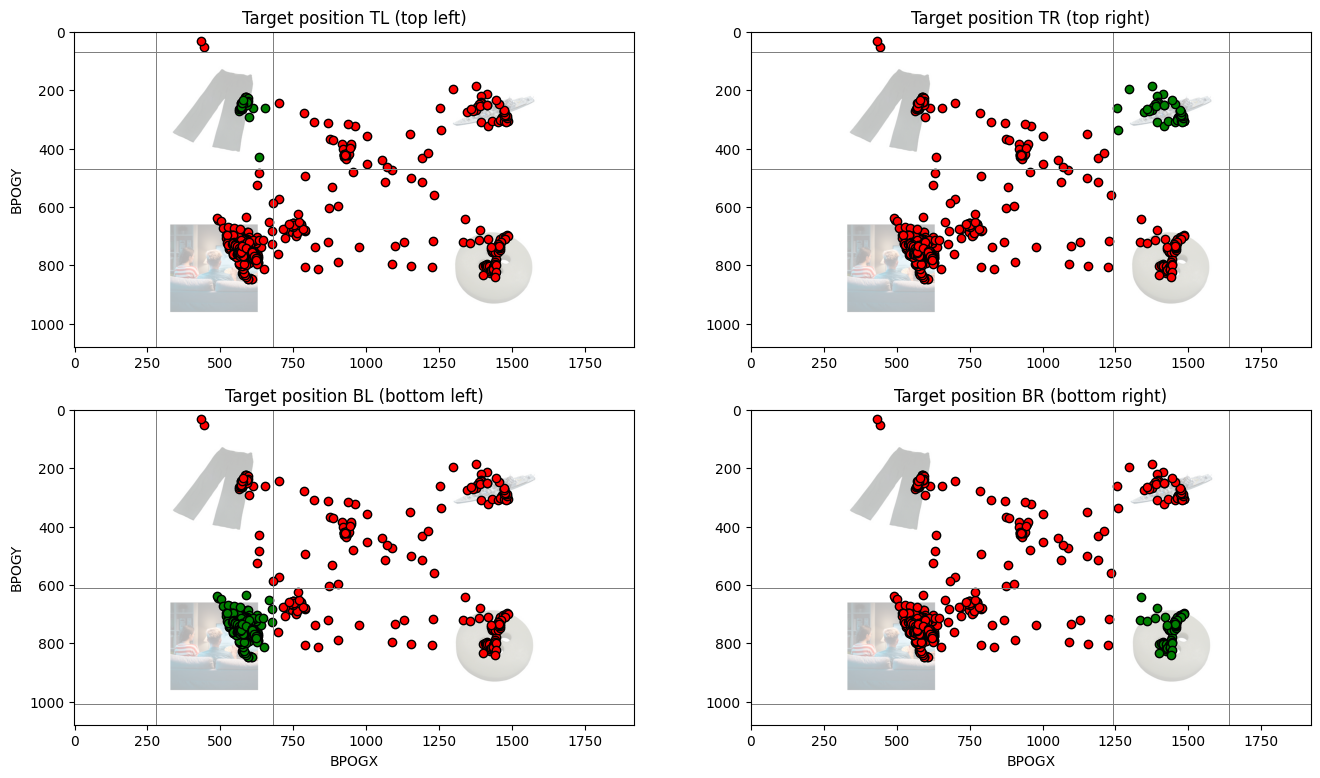

<Figure size 1600x900 with 0 Axes>

In [37]:
def calc_aoi(data, sentence_id):

    # set dict vor visualisation of position
    pos_dict = {"TL": "top left", "TR" : "top right", "BL" : "bottom left", "BR" : "bottom right"}

    # get samples with specific id
    data_subset = data.query(f"SENTENCE_ID=='{sentence_id}'")
    data_subset = data_subset.query(f"EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET'")

    # filter invalid samples
    data_subset = data_subset.query("BPOGV==1 and BPOGX>=0 and BPOGY >=0")
    
    # reset index
    data_subset = data_subset.reset_index(drop=True)

    # get first row of dataframe
    first_row = data_subset.iloc[0]

    stc = first_row["SENTENCE"]
    stc_id = first_row["SENTENCE_ID"]
    condition = data_subset.loc[0, "CONDITION"]

    # plot
    fig, ax = plt.subplots(2,2,figsize=(16,9))

    fig = plt.figure(figsize=(16, 9))
    
    # show background image
    for a in ax.flatten():
        im = plt.imread(exp_stimuli_folder + stc_id + "-" + condition + ".png")
        a.imshow(im, alpha=.3)
    
    for i in range(0, 2):
        for j in range(0, 2): 
            
            for index, value in data_subset['BPOGX'].items():

                x_rel = data_subset.at[index, 'BPOGX']
                y_rel = data_subset.at[index, 'BPOGY']
                
                pos = ""
                if i == 0 and j == 0:
                    pos = "TL"
                elif i == 0 and j == 1:
                    pos = "TR"
                elif i == 1 and j == 0:
                    pos = "BL"
                elif i == 1 and j == 1:
                    pos = "BR"

                # print lines of bounding box
                tldat = get_bounding_box_coords(pos)
                ax[i, j].axvline(x = tldat[0], color = 'grey', linewidth=.5)
                ax[i, j].axvline(x = tldat[1], color = 'grey', linewidth=.5)
                ax[i, j].axhline(y = tldat[2], color = 'grey', linewidth=.5)
                ax[i, j].axhline(y = tldat[3], color = 'grey', linewidth=.5)

                # plot sample
                ax[i, j].plot(x_rel*display["width"], y_rel*display["height"], marker='o', markeredgecolor='black', linewidth=10, color='green' if bpog_in_target_bbox(x_rel, y_rel, pos)  else 'red')
                

                # set labels
                ax[i, j].set_title(f"Target position {pos} ({pos_dict[pos]})")
                
                if (i == 1):
                    ax[i, j].set_xlabel('BPOGX')
                if (j == 0):
                    ax[i, j].set_ylabel('BPOGY')

    # titles
    fig.suptitle("Verification of area of interest detection algorithem for subject " + str(subject_no) + " and sentence (ID: " + stc_id + ", Condition: " + condition + "):  " + stc)

    # display plot
    plt.show()
    
    # save plot to assets
    fig.savefig(f'{plots_folder_name}/4-analysis-aoi_alg_{str(sentence_id)}_{condition.lower()}.png')


calc_aoi(data, 33)

### 4.3.2. Target Ratio and Non-Target Ratio

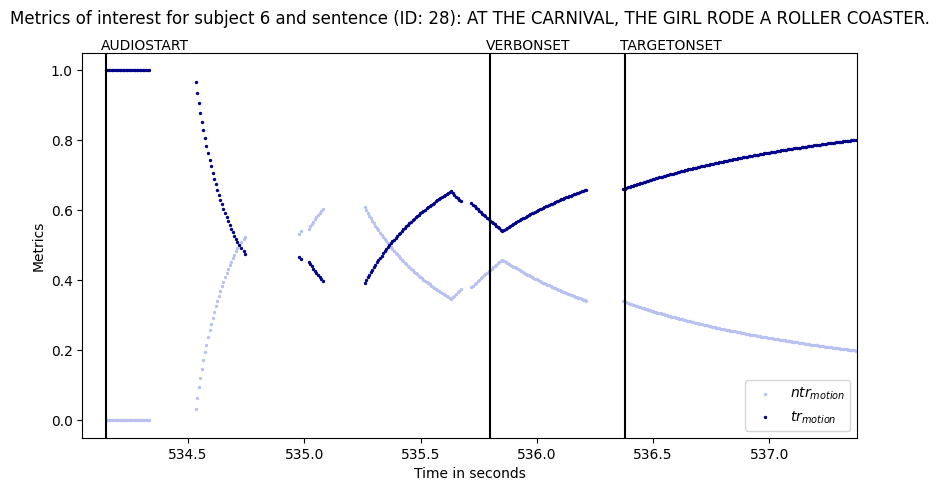

In [38]:
def calc_tr_ntr(data, highlight, sentence_id):

    # get samples with specific id
    data_subset = data.query(f"SENTENCE_ID=='{sentence_id}'")
    data_subset = data_subset.query(f"EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET'")
    
    # filter invalid samples
    data_subset = data_subset.query("BPOGV==1 and BPOGX>=0 and BPOGY >=0")
    
    # reset index
    data_subset = data_subset.reset_index(drop=True)

    # get cues
    audiostart = data_subset.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
    verb_onset = data_subset.query("EVENT=='VERBONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
    target_onset = data_subset.query("EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]

    # get first row of dataframe
    first_row = data_subset.iloc[0]

    stc = first_row["SENTENCE"]
    stc_id = first_row["SENTENCE_ID"]
    condition = data_subset.loc[0, "CONDITION"]
    t_pos = first_row["TARGET_POS"]


    for index, row in data_subset.iterrows():
        
        idx = index + 1

        x = row["BPOGX"]
        y = row["BPOGY"]
        in_b_box = bpog_in_target_bbox(x, y, t_pos)
        
        # if first index
        if index == 0:
            if in_b_box:
                data_subset.at[index, "TARGET_HITS_CUMMUL"] = 1
                data_subset.at[index, "TARGET_RATIO"] = 1
            else:
                data_subset.at[index, "TARGET_HITS_CUMMUL"] = 0
                data_subset.at[index, "TARGET_RATIO"] = 0
        else:
            if in_b_box:
                data_subset.at[index, "TARGET_HITS_CUMMUL"] = data_subset.at[index-1, "TARGET_HITS_CUMMUL"] + 1
            else:
                data_subset.at[index, "TARGET_HITS_CUMMUL"] = data_subset.at[index-1, "TARGET_HITS_CUMMUL"]
            data_subset.at[index, "TARGET_RATIO"] = data_subset.at[index, "TARGET_HITS_CUMMUL"]/idx
    
    for index, row in data_subset.iterrows():
        data_subset.at[index, "NONTARGET_RATIO"] = 1-data_subset.at[index, "TARGET_RATIO"]


    # plot
    fig = plt.figure(figsize=(10,5))

    plt.scatter(data_subset["TIME"],data_subset["NONTARGET_RATIO"], s=2,color="#b8c1f2",label="$ntr_{"+condition.lower()+"}$")
    plt.scatter(data_subset["TIME"],data_subset["TARGET_RATIO"], s=2,color="darkblue",label="$tr_{"+condition.lower()+"}$")

    # labels and ticks    
    plt.axvline(x = audiostart, color = 'r' if 'a' in highlight else 'k')
    plt.text(audiostart-0.02, 1.06, 'AUDIOSTART', color = 'r' if 'a' in highlight else 'k')
    plt.axvline(x = verb_onset, color = 'r' if 'v' in highlight else 'k')
    plt.text(verb_onset-0.02, 1.06, 'VERBONSET', color = 'r' if 'v' in highlight else 'k')
    plt.axvline(x = target_onset, color = 'r' if 't' in highlight else 'k')
    plt.text(target_onset-0.02, 1.06, 'TARGETONSET', color = 'r' if 't' in highlight else 'k')

    plt.title(f"Metrics of interest for subject {subject_no} and sentence (ID: {stc_id}): {stc}\n")
    plt.xlim((audiostart-0.1, target_onset+1))
    plt.ylim((-0.05,1.05))
    plt.ylabel("Metrics")
    plt.xlabel("Time in seconds")
    plt.legend(loc='lower right')

    # display plot
    plt.show()

    # save plot to assets
    fig.savefig(f'{plots_folder_name}/4-analysis-metrics_{str(sentence_id)}_{condition.lower()}.png')


calc_tr_ntr(data, "", 28)

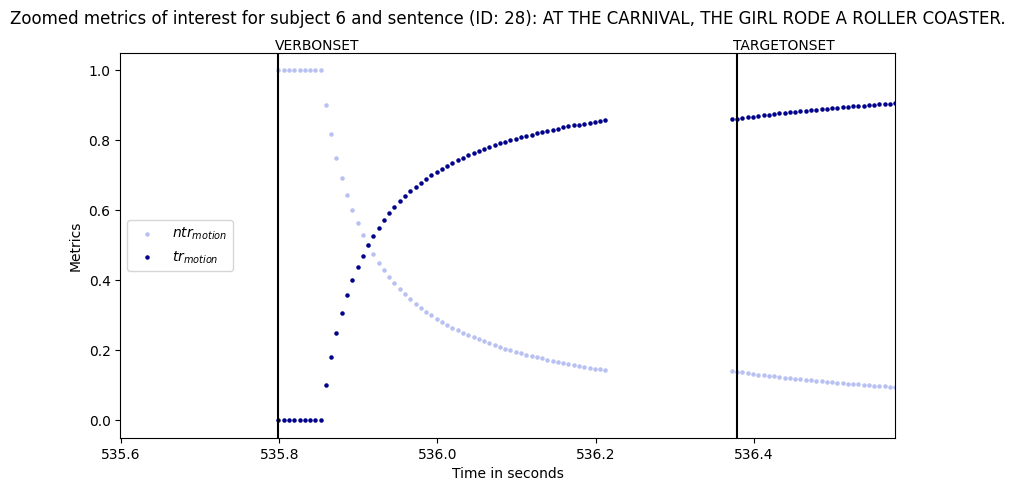

In [39]:
def calc_tr_ntr_zoomed(data, highlight, sentence_id):

    # get samples with specific id
    data_subset = data.query(f"SENTENCE_ID=='{sentence_id}'")
    data_subset = data_subset.query(f"EVENT=='VERBONSET' or EVENT=='TARGETONSET'")
    
    # filter invalid samples
    data_subset = data_subset.query("BPOGV==1 and BPOGX>=0 and BPOGY >=0")
    
    # reset index
    data_subset = data_subset.reset_index(drop=True)

    # get cues
    verb_onset = data_subset.query("EVENT=='VERBONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
    target_onset = data_subset.query("EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
    
    # get first row of dataframe
    first_row = data_subset.iloc[0]

    stc = first_row["SENTENCE"]
    stc_id = first_row["SENTENCE_ID"]
    condition = data_subset.loc[0, "CONDITION"]
    t_pos = first_row["TARGET_POS"]


    for index, row in data_subset.iterrows():
        
        idx = index + 1

        x = row["BPOGX"]
        y = row["BPOGY"]
        in_b_box = bpog_in_target_bbox(x, y, t_pos)

        # if first index
        if index == 0:
            if in_b_box:
                data_subset.at[index, "TARGET_HITS_CUMMUL"] = 1
                data_subset.at[index, "TARGET_RATIO"] = 1
            else:
                data_subset.at[index, "TARGET_HITS_CUMMUL"] = 0
                data_subset.at[index, "TARGET_RATIO"] = 0
        else:
            if in_b_box:
                data_subset.at[index, "TARGET_HITS_CUMMUL"] = data_subset.at[index-1, "TARGET_HITS_CUMMUL"] + 1
            else:
                data_subset.at[index, "TARGET_HITS_CUMMUL"] = data_subset.at[index-1, "TARGET_HITS_CUMMUL"]
            data_subset.at[index, "TARGET_RATIO"] = data_subset.at[index, "TARGET_HITS_CUMMUL"]/idx
    
    for index, row in data_subset.iterrows():
        data_subset.at[index, "NONTARGET_RATIO"] = 1-data_subset.at[index, "TARGET_RATIO"]


    # plot
    fig = plt.figure(figsize=(10,5))

    plt.scatter(data_subset["TIME"],data_subset["NONTARGET_RATIO"], s=5,color="#b8c1f2",label="$ntr_{"+condition.lower()+"}$")
    plt.scatter(data_subset["TIME"],data_subset["TARGET_RATIO"],  s=5, color="darkblue",label="$tr_{"+condition.lower()+"}$")
    
    plt.axvline(x = verb_onset, color = 'r' if 'v' in highlight else 'k')
    plt.text(verb_onset-0.005, 1.06, 'VERBONSET', color = 'r' if 'v' in highlight else 'k')
    plt.axvline(x = target_onset, color = 'r' if 't' in highlight else 'k')
    plt.text(target_onset-0.005, 1.06, 'TARGETONSET', color = 'r' if 't' in highlight else 'k')

    plt.xlim((verb_onset-.2, target_onset+.2))
    plt.ylim((-0.05,1.05))
    plt.ylabel("Metrics")
    plt.xlabel("Time in seconds")
    plt.title(f"Zoomed metrics of interest for subject {subject_no} and sentence (ID: {stc_id}): {stc}\n")

    plt.legend(loc='center left')

    # display plot
    plt.show()

    # save plot to assets
    fig.savefig(f'{plots_folder_name}/4-analysis-zoomed_metrics_{str(sentence_id)}_{condition.lower()}.png')


calc_tr_ntr_zoomed(data, "", 28)